<a href="https://colab.research.google.com/github/Check-Your-Skin/checkyourskin-ml_model/blob/train-cnn-ham10000/Data%20Preparation/HAM10000_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import**

In [ ]:
import os
import io
import shutil
import zipfile
import random

import pandas as pd
from glob import glob
from PIL import Image
from google.colab.patches import cv2_imshow
from concurrent.futures import ThreadPoolExecutor
import cv2

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight, resample
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization
from keras import metrics
from keras.metrics import Precision, Recall
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import numpy as np

#Data Preparation

## Load pkl file

In [ ]:
#Load DataFrame from Drive
df = pd.read_pickle('/content/drive/MyDrive/ML-Models/HAM10000_28x28_5000.pkl')
df['label'].value_counts()

label
1    5000
4    5000
3    5000
2    5000
0    5000
6    5000
5    5000
Name: count, dtype: int64

## Rescaling and splitting data

In [ ]:
x = np.asarray(df['image'].to_list())
x = x / 255
y = df['label']
y = to_categorical(y, num_classes=7)
x_train, x_sum, y_train, y_sum = train_test_split(x, y, train_size=0.7, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_sum, y_sum, test_size=0.5)

In [ ]:
print('Train: ',len(x_train))
print('Test: ',len(x_test))
print('Validation: ',len(x_valid))

Train:  24500
Test:  5250
Validation:  5250


##Calculating Class Weights

In [ ]:
Y_train = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(Y_train),y=Y_train)
class_weights = dict(zip(np.unique(Y_train),class_weights))
class_weights

{0: 0.9891468955073195,
 1: 0.9822055137844612,
 2: 1.0123998966675278,
 3: 1.0123998966675278,
 4: 0.9926545086119554,
 5: 1.0105724600309438,
 6: 1.0015333503705597}

#Build Model

## Convolutional Neural Network

## With Hyperparametersearch

### Model 1

#### Architecture

In [ ]:
def call_existing_code(conv_1_1_filters, conv_1_2_filters, conv_2_1_filters, conv_2_2_filters, conv_3_1_filters, conv_3_2_filters, activation_1_1, activation_1_2, activation_2_1, activation_2_2, activation_3_1, activation_3_2, activation_4_1, activation_4_2, activation_4_3, rate_1, rate_2, rate_3, units_1, units_2, units_3, lr) :
  model = Sequential()

  # Convolutional Block 1
  model.add(Conv2D(input_shape=(128,128,3), filters=conv_1_1_filters, kernel_size=(3, 3), padding="same", activation=activation_1_1))
  model.add(Conv2D(filters=conv_1_2_filters, kernel_size=(3, 3), padding="same", activation=activation_1_2))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(BatchNormalization())

  # Convolutional Block 2
  model.add(Conv2D(filters=conv_2_1_filters, kernel_size=(3, 3), padding="same", activation=activation_2_1))
  model.add(Conv2D(filters=conv_2_2_filters, kernel_size=(3, 3), padding="same", activation=activation_2_2))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(BatchNormalization())

  # Convolutional Block 3
  model.add(Conv2D(filters=conv_3_1_filters, kernel_size=(3, 3), padding="same", activation=activation_3_1))
  model.add(Conv2D(filters=conv_3_2_filters, kernel_size=(3, 3), padding="same", activation=activation_3_2))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dropout(rate=rate_1))
  model.add(Dense(units=units_1, activation=activation_4_1))
  model.add(Dropout(rate=rate_2))
  model.add(Dense(units=units_2, activation=activation_4_2))
  model.add(Dropout(rate=rate_3))
  model.add(Dense(units=units_3, activation=activation_4_3))
  model.add(BatchNormalization())

  model.add(Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

  optimizer_name = 'Adam'

  loss_name = 'categorical_crossentropy'

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss=loss_name,
                metrics = [
                      metrics.Precision(),
                      metrics.Recall(),
                      tfa.metrics.F1Score(num_classes=7, average='macro',threshold=0.5),
                      metrics.FalsePositives(),
                      metrics.FalseNegatives(),
                      metrics.TruePositives(),
                      metrics.TrueNegatives(),
                      metrics.AUC()
                  ])

  return model

#### Build model

In [ ]:
model_architecture = None

def build_model(hp):
    # filters
    # block 1
    conv_1_1_filters = hp.Int('conv_1_1_filters', min_value=16, max_value=64, step=4)
    conv_1_2_filters = hp.Int('conv_1_2_filters', min_value=16, max_value=64, step=4)

    # block 2
    conv_2_1_filters = hp.Int('conv_2_1_filters', min_value=32, max_value=96, step=4)
    conv_2_2_filters = hp.Int('conv_2_2_filters', min_value=32, max_value=96, step=4)

    # block 3
    conv_3_1_filters = hp.Int('conv_3_1_filters', min_value=96, max_value=196, step=16)
    conv_3_2_filters = hp.Int('conv_3_2_filters', min_value=96, max_value=196, step=16)

    # units
    units_1 = hp.Int('dense_units_1', min_value=256, max_value=780, step=32)
    units_2 = hp.Int('dense_units_2', min_value=128, max_value=300, step=16)
    units_3 = hp.Int('dense_units_3', min_value=16, max_value=128, step=16)


    # activation
    activation_1_1 = hp.Choice('activation_1_1', ['relu', 'elu', 'selu', 'tanh'])
    activation_1_2 = hp.Choice('activation_1_2', ['relu', 'elu', 'selu', 'tanh'])

    activation_2_1 = hp.Choice('activation_2_1', ['relu', 'elu', 'selu', 'tanh'])
    activation_2_2 = hp.Choice('activation_2_2', ['relu', 'elu', 'selu', 'tanh'])

    activation_3_1 = hp.Choice('activation_3_1', ['relu', 'elu', 'selu', 'tanh'])
    activation_3_2 = hp.Choice('activation_3_2', ['relu', 'elu', 'selu', 'tanh'])

    activation_4_1 = hp.Choice('activation_4_1', ['relu', 'elu', 'selu', 'tanh'])
    activation_4_2 = hp.Choice('activation_4_2', ['relu', 'elu', 'selu', 'tanh'])
    activation_4_3 = hp.Choice('activation_4_3', ['relu', 'elu', 'selu', 'tanh'])



    # learning & dropoutrate
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    rate_1 = hp.Float('dropout_rate_1', min_value=0.2, max_value=0.8, step=0.1)
    rate_2 = hp.Float('dropout_rate_2', min_value=0.2, max_value=0.8, step=0.1)
    rate_3 = hp.Float('dropout_rate_3', min_value=0.2, max_value=0.8, step=0.1)

    # optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])

    model = call_existing_code(conv_1_1_filters=conv_1_1_filters, conv_1_2_filters=conv_1_2_filters, conv_2_1_filters=conv_2_1_filters, conv_2_2_filters=conv_2_2_filters,
                               conv_3_1_filters=conv_3_1_filters, conv_3_2_filters=conv_3_2_filters,
                               activation_1_1=activation_1_1, activation_1_2=activation_1_2, activation_2_1=activation_2_1, activation_2_2=activation_2_2,
                               activation_3_1=activation_3_1, activation_3_2=activation_3_2, activation_4_1=activation_4_1, activation_4_2=activation_4_2, activation_4_3=activation_4_3,
                               rate_1=rate_1, rate_2=rate_2, rate_3=rate_3,
                               units_1=units_1, units_2=units_2, units_3=units_3,lr=lr)



    model_architecture = model

    return model

build_model(keras_tuner.HyperParameters())

#### Start Keras Tuner

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tensorboard_callback = TensorBoard(log_dir='/tmp/tb_logs', histogram_freq=1)

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective('val_f1_score', direction='max'),
    max_trials=20,
    executions_per_trial=2,
    directory='output',
    project_name='image_classification'
)

In [ ]:
tuner.search(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=8, class_weight=class_weights, callbacks=[early_stopping, tensorboard_callback])

#### Get best hyperparameters

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_conv_1_1_filters = best_hps.get('conv_1_1_filters')
best_conv_1_2_filters = best_hps.get('conv_1_2_filters')
best_conv_2_1_filters = best_hps.get('conv_2_1_filters')
best_conv_2_2_filters = best_hps.get('conv_2_2_filters')
best_conv_3_1_filters = best_hps.get('conv_3_1_filters')
best_conv_3_2_filters = best_hps.get('conv_3_2_filters')
units_1 = best_hps.get('dense_units_1')
units_2 = best_hps.get('dense_units_2')
units_3 = best_hps.get('dense_units_3')
activation_1_1 = best_hps.get('activation_1_1')
activation_1_2 = best_hps.get('activation_1_2')
activation_2_1 = best_hps.get('activation_2_1')
activation_2_2 = best_hps.get('activation_2_2')
activation_3_1 = best_hps.get('activation_3_1')
activation_3_2 = best_hps.get('activation_3_2')
activation_4_1 = best_hps.get('activation_4_1')
activation_4_2 = best_hps.get('activation_4_2')
activation_4_3 = best_hps.get('activation_4_3')
rate_1 = best_hps.get('dropout_rate_1')
rate_2 = best_hps.get('dropout_rate_2')
rate_3 = best_hps.get('dropout_rate_3')
lr = best_hps.get('lr')

In [ ]:
print("Beste Hyperparameter:")
print("best_conv_1_1_filters =", best_conv_1_1_filters)
print("best_conv_1_2_filters =", best_conv_1_2_filters)
print("best_conv_2_1_filters =", best_conv_2_1_filters)
print("best_conv_2_2_filters =", best_conv_2_2_filters)
print("best_conv_3_1_filters =", best_conv_3_1_filters)
print("best_conv_3_2_filters =", best_conv_3_2_filters)
print("units_1 =", units_1)
print("units_2 =", units_2)
print("units_3 =", units_3)
print("activation_1_1 =", activation_1_1)
print("activation_1_2 =", activation_1_2)
print("activation_2_1 =", activation_2_1)
print("activation_2_2 =", activation_2_2)
print("activation_3_1 =", activation_3_1)
print("activation_3_2 =", activation_3_2)
print("activation_4_1 =", activation_4_1)
print("activation_4_2 =", activation_4_2)
print("activation_4_3 =", activation_4_3)
print("rate_1 =", rate_1)
print("rate_2 =", rate_2)
print("rate_3 =", rate_3)
print("lr =", lr)

In [ ]:
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

## Without Hyperparametersearch

### Model compilation

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')


def mode_compilation(learning_rate, loss_name):
  optimizer_name = 'Adam'

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=loss_name,
                  metrics = [
                        metrics.Precision(),
                        metrics.Recall(),
                        tfa.metrics.F1Score(num_classes=7, average='macro',threshold=0.5),
                        metrics.FalsePositives(),
                        metrics.FalseNegatives(),
                        metrics.TruePositives(),
                        metrics.TrueNegatives(),
                        metrics.AUC()
                    ])

### Model 1

In [ ]:
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(input_shape=(28,28,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Convolutional Block 2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Convolutional Block 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(units=32, activation="relu"))
model.add(BatchNormalization())

model.add(Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        3

In [ ]:
learning_rate = 0.0005

optimizer = Adam(learning_rate=learning_rate)

optimizer_name = 'Adam'

loss_name = 'categorical_crossentropy'

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

model.compile(optimizer=optimizer,
              loss=loss_name,
              metrics = [
                    metrics.Precision(),
                    metrics.Recall(),
                    metrics.FalsePositives(),
                    metrics.FalseNegatives(),
                    metrics.TruePositives(),
                    metrics.TrueNegatives(),
                    metrics.AUC()
                ])

In [ ]:
hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), batch_size=8, callbacks = [reduce_lr, early_stop])
#hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), batch_size=8, class_weight=class_weights)

Epoch 1/50
3063/3063 [==============================] - 37s 9ms/step - loss: 1.6114 - precision_2: 0.5807 - recall_2: 0.1498 - false_positives_2: 2649.0000 - false_negatives_2: 20831.0000 - true_positives_2: 3669.0000 - true_negatives_2: 144351.0000 - auc_2: 0.7673 - val_loss: 1.5717 - val_precision_2: 0.6701 - val_recall_2: 0.2349 - val_false_positives_2: 607.0000 - val_false_negatives_2: 4017.0000 - val_true_positives_2: 1233.0000 - val_true_negatives_2: 30893.0000 - val_auc_2: 0.7798 - lr: 5.0000e-04
Epoch 2/50
3063/3063 [==============================] - 26s 8ms/step - loss: 1.2781 - precision_2: 0.7007 - recall_2: 0.2871 - false_positives_2: 3004.0000 - false_negatives_2: 17466.0000 - true_positives_2: 7034.0000 - true_negatives_2: 143996.0000 - auc_2: 0.8601 - val_loss: 1.1966 - val_precision_2: 0.6904 - val_recall_2: 0.3823 - val_false_positives_2: 900.0000 - val_false_negatives_2: 3243.0000 - val_true_positives_2: 2007.0000 - val_true_negatives_2: 30600.0000 - val_auc_2: 0.8781

### Visualize CNN Architecture

In [ ]:
pip install visualkeras

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True, to_file='/content/cnn_architecture.png')

### Fit

In [ ]:
hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), batch_size=8, callbacks = [reduce_lr, early_stop])

#hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), batch_size=8, class_weight=class_weights, callbacks=[tensorboard_callback])

#Evaluation

In [ ]:
test_data = model.evaluate(x_test, y_test)

165/165 [==============================] - 1s 4ms/step - loss: 0.4747 - precision_2: 0.8596 - recall_2: 0.8290 - false_positives_2: 711.0000 - false_negatives_2: 898.0000 - true_positives_2: 4352.0000 - true_negatives_2: 30789.0000 - auc_2: 0.9806


## Start TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

## Plot of results

### Loss (Validation)

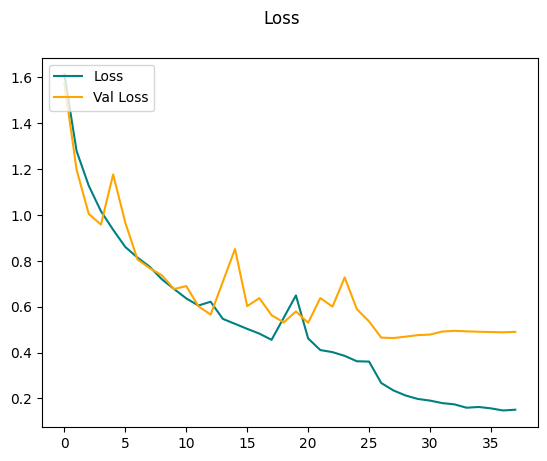

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Val Loss')
fig.suptitle('Loss')
plt.legend(loc='upper left')
plt.show()

### Precision (Validation)

In [ ]:
fig = plt.figure()
plt.plot(hist.history['precision'], color='teal', label='Precision')
plt.plot(hist.history['val_precision'], color='orange', label='Val Precision')
fig.suptitle('Precision')
plt.legend(loc='upper left')
plt.show()

### False negatives & False positives (Validation)

In [ ]:
fig = plt.figure()
plt.plot(hist.history['false_negatives'], color='teal', label='False_Negative')
plt.plot(hist.history['val_false_negatives'], color='cyan', label='Val_False_Negative')
plt.plot(hist.history['false_positives'], color='orange', label='False_Positive')
plt.plot(hist.history['val_false_positives'], color='magenta', label='Val_False_Positive')
fig.suptitle('FN & FP')
plt.legend(loc='upper left')
plt.show()

### Confusionmatrix

165/165 [==============================] - 1s 2ms/step


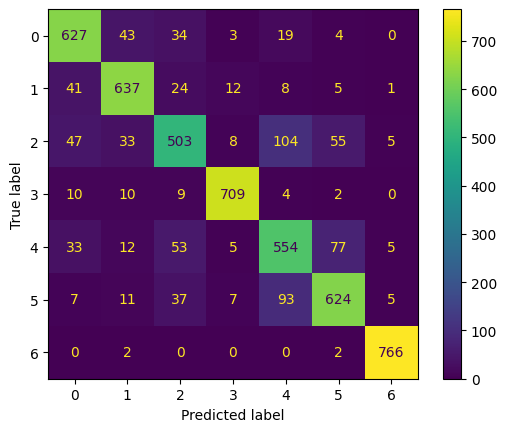

In [ ]:
Y_pred = model.predict(x_test)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(y_test,axis=1)
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
plt.show()

### Classifikationreport

In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       730
           1       0.85      0.88      0.86       728
           2       0.76      0.67      0.71       755
           3       0.95      0.95      0.95       744
           4       0.71      0.75      0.73       739
           5       0.81      0.80      0.80       784
           6       0.98      0.99      0.99       770

    accuracy                           0.84      5250
   macro avg       0.84      0.84      0.84      5250
weighted avg       0.84      0.84      0.84      5250



#Save / Load Model

In [ ]:
model.save('/content/drive/My Drive/ML-Models/resampling_28x28_5000.keras')

In [ ]:
model = load_model('/content/drive/My Drive/ML-Models/')